В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (
    LogisticRegression, 
    LinearRegression,
    Lasso, 
    Ridge, 
    ElasticNet
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Area under ROC score on Train dataset: 0.88


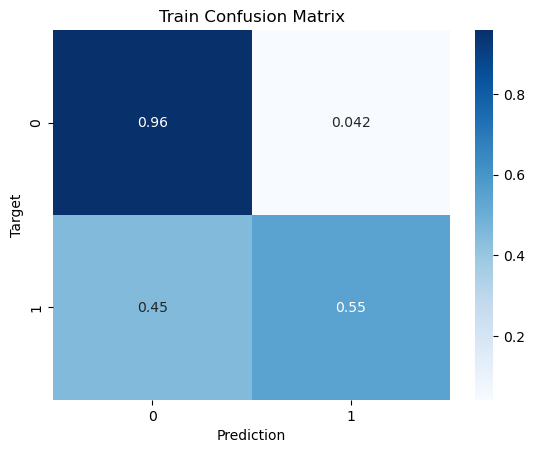

Area under ROC score on Validation dataset: 0.88


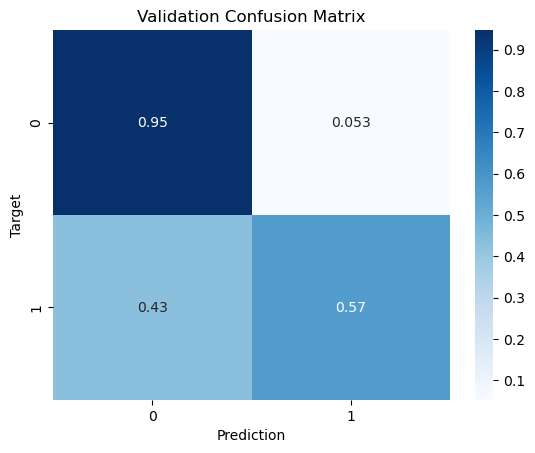

['bank_customer_churn_prediction.joblib']

In [2]:
data_path = r'C:\Users\olha.koltun\OneDrive - Trico\ML Course\data\bank-customer-churn-prediction-dlu-course-c-2'
raw_df = pd.read_csv(os.path.join(data_path, 'train.csv'), index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[2:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    # Якщо пайплайн підтримує predict_proba, використовуємо його для обчислення ROC AUC
    if hasattr(model_pipeline, 'predict_proba'):
        # Припускаємо, що позитивний клас має індекс 1
        preds_proba = model_pipeline.predict_proba(inputs)[:, 1]
        roc_auc = roc_auc_score(targets, preds_proba)
    else:
        # Якщо predict_proba не доступний, використовуємо передбачені мітки
        roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank_customer_churn_prediction.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [3]:
def train_poly_pipeline(degree, 
                        train_inputs, train_targets, 
                        val_inputs, val_targets, 
                        numeric_cols, categorical_cols):
    # Трансформер числових ознак: генеруємо поліноми та масштабуємо
    numeric_transformer_poly = Pipeline(steps=[
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor_poly = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_poly, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    # Пайплайн із препроцесором та логістичною регресією
    model_poly_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_poly),
        ('classifier', LogisticRegression(solver='liblinear'))
    ])
    
    model_poly_pipeline.fit(train_inputs, train_targets)
    
    train_preds = predict_and_plot(
        model_poly_pipeline, train_inputs, train_targets, 
        f'Train (degree={degree})'
    )
    
    val_preds = predict_and_plot(
        model_poly_pipeline, val_inputs, val_targets, 
        f'Validation (degree={degree})'
    )
    
    return model_poly_pipeline, train_preds, val_preds

Area under ROC score on Train (degree=2) dataset: 0.93


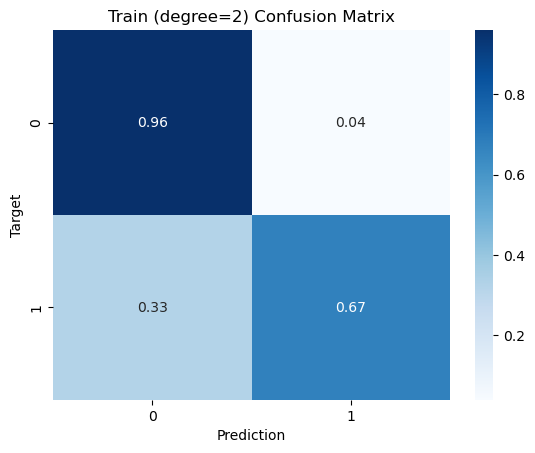

Area under ROC score on Validation (degree=2) dataset: 0.93


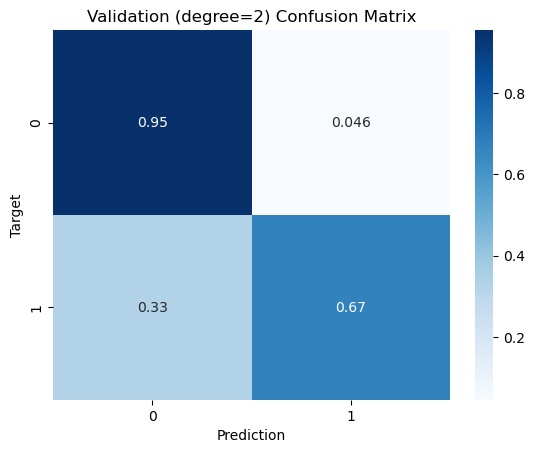

In [4]:
model2, train_preds2, val_preds2 = train_poly_pipeline(
    degree=2, 
    train_inputs=train_inputs, train_targets=train_targets, 
    val_inputs=val_inputs, val_targets=val_targets,
    numeric_cols=numeric_cols, categorical_cols=categorical_cols
)

**Висновок**

Модель показує однаково високий `ROC AUC` (0.93) на тренувальних і валідаційних даних. Також `confusion matrix` свідчить про дуже схожу якість класифікації. Це означає, що модель не має ознак ні `overfit`, ні `underfit` і добре генералізує.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train (degree=4) dataset: 0.94


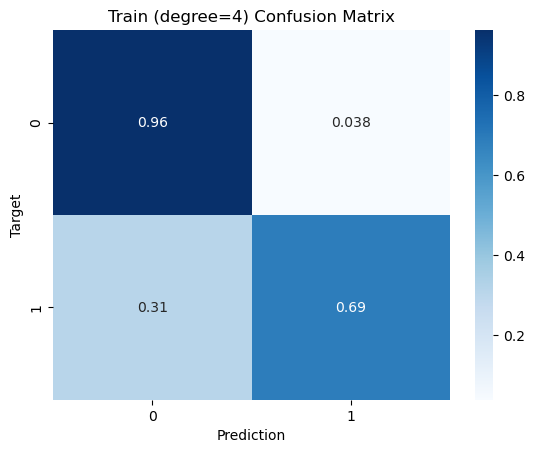

Area under ROC score on Validation (degree=4) dataset: 0.93


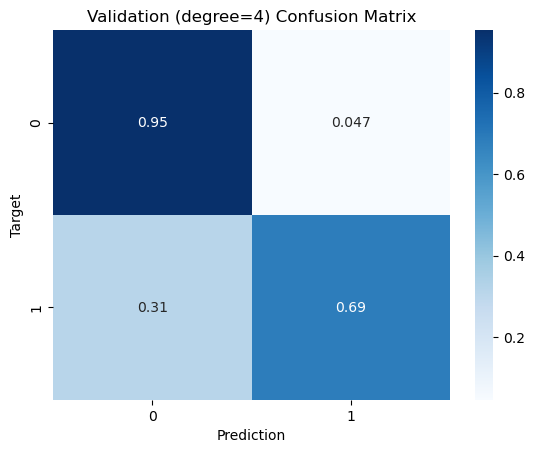

In [5]:
model4, train_preds4, val_preds4 = train_poly_pipeline(
    degree=4, 
    train_inputs=train_inputs, train_targets=train_targets, 
    val_inputs=val_inputs, val_targets=val_targets,
    numeric_cols=numeric_cols, categorical_cols=categorical_cols
)

**Висновок**

Модель має майже однаково високий `ROC AUC` (0.94 на тренуванні, 0.93 на валідації) й подібні `confusion matrix`. Це свідчить про відсутність вираженого `overfit` чи `underfit` і добру здатність моделі узагальнювати.

In [6]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(model_pipeline, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    inputs = input_df[numeric_cols + categorical_cols]
    proba = model_pipeline.predict_proba(inputs)[:,1]
    return proba

test_raw_df = pd.read_csv(os.path.join(data_path, 'test.csv'))
test_raw_df['Exited'] = predict_raw_df(model4, numeric_cols, categorical_cols, test_raw_df)

submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
submission_df['Exited'] = test_raw_df.set_index('id').loc[submission_df['id'], 'Exited'].values

print('First 5 rows of the submission file:')
print(submission_df.head())

submission_df.to_csv(os.path.join(data_path, 'submission_log_reg.csv'), index=False)
print('Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!')

First 5 rows of the submission file:
      id    Exited
0  15000  0.062240
1  15001  0.015420
2  15002  0.055672
3  15003  0.423174
4  15004  0.026674
Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [7]:
data_path = r'C:\Users\olha.koltun\OneDrive - Trico\ML Course\data'
raw_df = pd.read_csv(os.path.join(data_path, 'regression_data.csv'))

raw_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [8]:
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)

input_cols = list(raw_df.columns)[:-1]
target_col = 'target'

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('poly_features', PolynomialFeatures(degree=5)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(degree=5)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('regressor', LinearRegression())])

RMSE on Training set: 0.000000


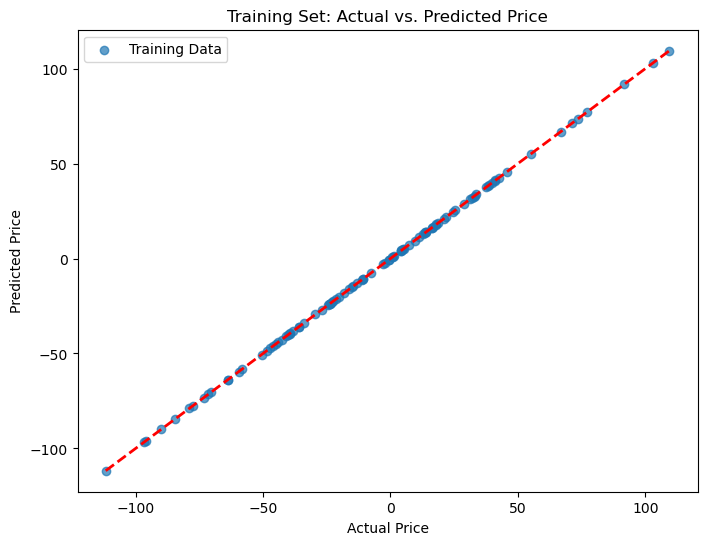

RMSE on Test set: 12.092195


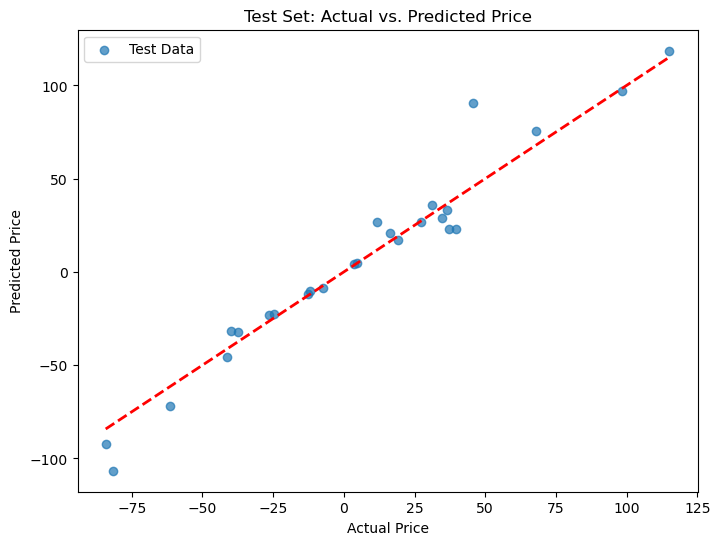

In [9]:
def predict_and_evaluate(model, X, y, set_name=''):
    """
    Обчислює RMSE і будує графік Actual vs. Predicted.
    set_name: назва вибірки (Train, Test, Val тощо).
    """
    # Передбачення
    y_pred = model.predict(X)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f"RMSE on {set_name} set: {rmse:.6f}")
    
    # Побудова діаграми розсіювання (Actual vs. Predicted)
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.7, label=f'{set_name} Data')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{set_name} Set: Actual vs. Predicted Price')
    plt.legend()
    plt.show()

predict_and_evaluate(model_pipeline, train_inputs, train_targets, set_name='Training')
predict_and_evaluate(model_pipeline, test_inputs, test_targets, set_name='Test')

**Висновок**

З **нульовим** `RMSE` на тренувальній вибірці (0.00) та порівняно **високим** (12.09) на тесті ми бачимо, що модель ідеально описує **тренувальні дані**, але на **тестових** працює гірше. Це типова ознака **перенавчання**, коли модель «вивчила» особливості тренувального набору надто добре й не узагальнює на нові дані.  

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [10]:
def create_and_train_pipeline(regressor, degree=20):
    """
    Створює Pipeline з PolynomialFeatures(degree), StandardScaler(),
    і переданим регресором, та виконує fit на тренувальних даних.
    """
    numeric_transformer = Pipeline(steps=[
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_cols),
    ])

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    model_pipeline.fit(train_inputs, train_targets)
    return model_pipeline

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(6)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(6)

    return dict(train=train_rmse, test=test_rmse)

models = [
    Lasso(),
    Ridge(),
    ElasticNet()
]

for model in models:
    model_pipeline = create_and_train_pipeline(model)
    eval_results  = evaluate_model(model_pipeline, train_inputs, train_targets, test_inputs, test_targets)
    print(f'{str(model)}: {eval_results}\n')

Lasso(): {'train': 1.479369, 'test': 1.392128}

Ridge(): {'train': 1.05367, 'test': 27.797604}

ElasticNet(): {'train': 12.044328, 'test': 20.624002}



**Порівняння:**

1. **Лінійна регресія** (`degree`=5): `RMSE` = 0.00 (Train) та 12.09 (Test) — яскраве перенавчання, адже на тренуванні помилка нульова, а на тесті досить велика.
2. **Ridge**: `RMSE` ≈ 1.05 (Train) та 27.80 (Test) — ще сильніше перенавчання, ніж лінійна регресія; модель надто «прив’язалася» до навчальної вибірки.
3. **ElasticNet**: `RMSE` ≈ 12.04 (Train) та 20.62 (Test) — доволі великі обидві помилки; немає ознак сильного перенавчання, проте якість загалом нижча.
4. **Lasso**: `RMSE` ≈ 1.48 (Train) та 1.39 (Test) — найкраще узагальнює, оскільки різниця між тренувальним і тестовим результатом мінімальна. Ймовірно, вона «відсікає» зайві ознаки за допомогою L1-регуляризації. Щоб переконатися, проаналізуємо коефіцієнти та подивитися, які саме фічі були занулені.

In [11]:
model = Lasso()
model_pipeline = create_and_train_pipeline(model)

# Витягуємо PolyFeatures із числового препроцесора
poly = model_pipeline['preprocessor'].named_transformers_['num'].named_steps['poly_features']

# Отримуємо імена фіч
feature_names = poly.get_feature_names_out(train_inputs.columns)

# Отримуємо коефіцієнти з регресора
coefs = model_pipeline['regressor'].coef_

# Створюємо DataFrame із фіч та їхніх коефіцієнтів
coefs_df = pd.DataFrame({
    'feature_name': feature_names,
    'value': coefs.round(5)
})

coefs_df.shape

(53130, 2)

In [12]:
# Додаємо стовпець із абсолютними значеннями
coefs_df['abs_value'] = coefs_df['value'].abs()

# Сортуємо за abs_value
coefs_df_sorted = coefs_df.set_index('feature_name').sort_values(by='abs_value', ascending=False)

# Виводимо перші 10
display(coefs_df_sorted.head(10).style.background_gradient(cmap='Blues'))

,value,abs_value
feature_name,,
feature_4,43.120750,43.120750
1,0.000000,0.000000
feature_1^7 feature_3^3 feature_4^8 feature_5,-0.000000,0.000000
feature_1^7 feature_3^4 feature_4^8,-0.000000,0.000000
feature_1^7 feature_3^4 feature_4^7 feature_5,0.000000,0.000000
feature_1^7 feature_3^4 feature_4^6 feature_5^2,-0.000000,0.000000
feature_1^7 feature_3^4 feature_4^5 feature_5^3,0.000000,0.000000
feature_1^7 feature_3^4 feature_4^4 feature_5^4,-0.000000,0.000000
feature_1^7 feature_3^4 feature_4^3 feature_5^5,0.000000,0.000000


З таблиці видно, що ознака `feature_4` має набагато більший коефіцієнт, тоді як решта або занулені, або дуже малі. Це означає, що модель фактично використовує переважно одну ключову фічу (чи її похідні) і відсікає решту, сприймаючи їх як менш релевантні або зайві.